**Chapter 3 – Classification**

_This notebook contains all the sample code and solutions to the exercices in chapter 3._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    #path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    path = os.path.join(PROJECT_ROOT_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# MNIST

We download some image data using an `sklearn` download function from the **MNIST** repository.

In [2]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    print("Could not download MNIST data from mldata.org, trying alternative...")

    # Alternative method to load MNIST, if mldata.org is down
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Success!")

In `sklearn`, data is stored in a standard dictionary wrapper, with the raw data
in an `m x n` array under the key `data`.  The images are images of the digits `0` through `9`; our classification task is to recognize the digits, so there are 10 classes stored
under the key `target`.

In [3]:
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

Each 1D data array is 784 digits long; 784 is $28^{2}$, so each data array represents
a square 28x28 image.

In [6]:
28*28

784

The `matplotlib` library has simple image display capabilities. Given a numerical array
it will display this as an image.

5.0
Saving figure some_digit_plot


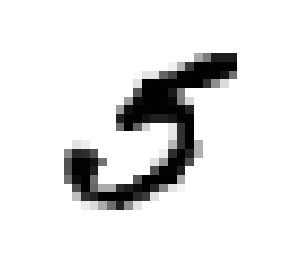

In [8]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_digit_index = 36000
print((y[some_digit_index]))
some_digit = X[some_digit_index]
plot_digit(some_digit)
save_fig("some_digit_plot")
plt.show()

In [9]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Let's do some example images out of the 70,000 we have to choose from.  We want several
examples of multiple digits, to see the variation in the ways  a digit can appear,
and several different digits.  With a little tinkering it becomes clear what rows we want to sample.  The bottom line is that we build a 100x784 array
containing just our examples and display that.  

We use a very useful `numpy` function `r_`, which does row-wise concatenation; if we pass in 3 2D arrays with `m`, `n`, and `p` rows, it returns one array
with `m+n+p` rows.

(100, 784)
Saving figure more_digits_plot


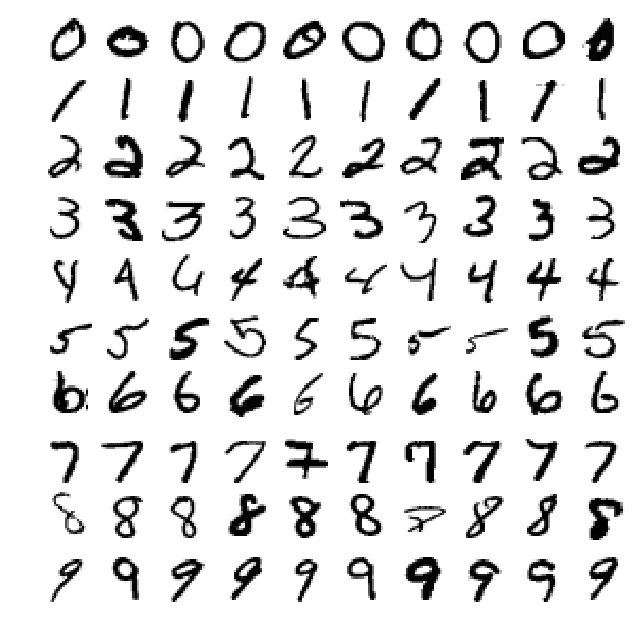

In [186]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
print((example_images.shape))
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [188]:
shuffle_index = rnd.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Sanity check 1:  Did we produce an array with all the number we started with?

In [189]:
np.arange(60000).sum(),shuffle_index.sum()

(1799970000, 1799970000)

Sanity check 2:  Are the examples of particular digits indeed randomly scattered?

In [190]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [191]:
y_train_5[:20]

array([False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False,  True], dtype=bool)

The `y_train_5` array will turn out to be useful for another purpose in the next
section.

# Binary classifier

We'll train a classifier that learns using a **stochastic gradient descent algorithm**.

That name specifies the kind of numerical algorithm used to compute the classifier,
as well as a kind of learning (**discriminative learning**).  It actually doesn't
determine the learning model, which is fixed by specifying something called the
**loss function**.  We're going to choose the loss function `hinge`, which turns out
to give us a kind of model called a **maximum margin model** (used in SVMs, for example), and we're going to **smooth** that model with penalty type called `l2`, which discourages 
weight vectors that get very long.

The choice of the learner and the training is done in the next few lines of code. 
The `fit` method actually trains the classifier on the training data.  Notice that
the target array we're using for training is the `y_train_5` array we created
in the last section.  So we're going to tackle a **binary classification**
problem first, discriminating the digit `5` from everything else. Notice that the 
`fit` method returns the entire classifier object, and shows us all the parameters
the learner used.  The `loss` and `penalty` parameters discussed above are both there, even though they weren't specified in creating the classifier object, because they're
defaults, and there are lots of other parameters we haven't discussed.

In [192]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

Let's try it out on an example.

In [193]:
print((sgd_clf.predict([some_digit]),y[some_digit_index]))

[ True] 5.0


Did we get it right?

Now let's see how we do with a larger set of data using an evaluation
method called cross-validation, where we separate part of the training
data to use as our test, and train on the rest.  We'll do
3-way cross-validation, meaning we do 3 different training runs,
holding out and testing on a different third of the training data on each,
and we'll evaluate ourselves using **accuracy**.

In [194]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9502 ,  0.96565,  0.96495])

Not bad, or so it seems.

In [195]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print((n_correct / len(y_pred)))

0.9502
0.96565
0.96495


Now let's try a silly classifier.  It never sees any training
data; it does no training at all; it just always says "no."

In [196]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Now we evaluate this learner --- which we'll call our **baseline learner**
the same way we evaluated our SGD learner.

In [197]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.909  ,  0.90715,  0.9128 ])

Uh oh.  Maybe we didn't do as well as we thought.  Of course: 90% of the data
is non-5's, so by guessing no all the time we get a 90% right without knowing
a thing.

However, notice that our SGD learner did **better** than 90%; all its scores are
above 95%. One of way looking at this, and it turns out to be useful, is that
our learner has reduced the baseline error rate by 50%.  That's a win.  It has learned
something about what makes a digit a 5.

Let's try to get more systematic about what's good an dbad about our classifier.
To do that, we need to abandon **accuracy** as an evaluation measure.

## Precision and  Recall

In [198]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

The evaluation metric we used was accuracy:

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$


But we have seen that accuracy does not tell the whole story. For a fuller picture, we turn to the **confusion matrix**. In the case of binary classification, the confusion matrix is a 2-by-2 matrix laying out correct and incorrect predictions made in each label as follows:

```
               +---------------------------------------------+
               |                Predicted label              |
               +----------------------+----------------------+
               |          (+1)        |         (-1)         |
 +-------+-----+----------------------+----------------------+
 | True  |(+1) | # of true positives  | # of false negatives |
 | label +-----+----------------------+----------------------+
 |       |(-1) | # of false positives | # of true negatives  |
 +-------+-----+----------------------+----------------------+
```

The diagonal that contains the word "true" sums up the correct responses.  The diagonal
that contains the word "false" sums up mistakes.

To print out the confusion matrix for a classifier, use `sklearn.metric.confusion_matrix`:

In [199]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

Let's say you are interested in reducing mistakes. In particular, let's say it's
false positives that bother you. You want to reduce the percentage of false positives to be less than, say, 3.5% of all positive predictions. This is where **precision** comes in:

$$
[\text{precision}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all data points with positive predictions]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false positives}]}
$$

So to keep the percentage of false positives below 3.5% of positive predictions, we must raise the precision to 96.5% or higher.

**First**, let us compute the precision of the SGD classifier on the **test_data**.

In [200]:
from sklearn.metrics import precision_score

precision_score(y_train_5, y_train_pred)

0.76871350203503808

In [201]:
4344 / (4344 + 1307)

0.7687135020350381

Next we think about reducing the other kind of mistakes, false negatives.  We want to catch 
all cases of the disease, even if we end up subjecting some patients to unnecessary tests.

This is where **recall** comes in.

$$
[\text{recall}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all positive data points]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false negatives}]}
$$
 

In `sklearn` this is

In [202]:
from sklearn.metrics import recall_score

recall_score(y_train_5, y_train_pred)

0.80132816823464303

In [204]:
4344 / (4344 + 1077)

0.801328168234643

So we've introduced two numbers, **precision** and **recall**.  Which should we care about?

Well, that depends.  As we show below.

First, let's talk a little about how our classifier works.

## Precision/Recall Tradeoff

What actually happens during training is that our digit classifier assigns weights to the various
features of our images (simplifying, the places in the image where a pixel is **on** or "black").

At the end it has built a kind of numerical model of what an ideal 5 looks like, and that
allows it to assign a **score** to each image it is presented with.  We can see what that
score is by using the classifier's `decision_function` method.

In [27]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 161855.74572176])

Of course numbers are wonderful, but the classification task requires a yes/no decision.

So take an image score and reach a decision as to whether that image is a 5 or not,
we also need a **threshhold**.

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

Now we are classifying.  We just said, yes, that image is a 5. 

Now let's be stricter about what counts as a 5.   We set the threshhold **higher**.

In [29]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

And now the same classifier, trained on the same data, says "no" for this example.

Changing the threshhold changes the behavior of the classifier, and it may have dramatic
practical consequences, but it doesn't change the classifier.  For measuring
the effects of changing the threshhold, precision and recall are exactly the right tools.

Let's do cross-validation again, this time, just returning a set of scores,
and let's look at the effects of changing the threshhold on a few examples.

In [207]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

(100, 784)
Saving figure precison_recall_tradeoff


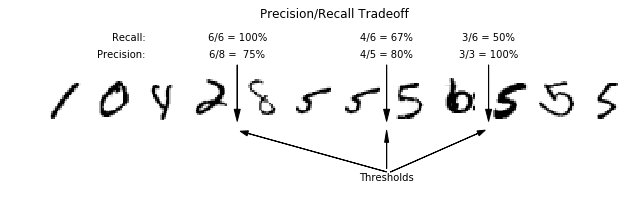

In [170]:
def precision_recall_trade(instances, images_per_row=10, starting_row = 0, ending_row = None,
                   **options):
    global rimages,ax
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    if ending_row is None:
        ending_row is n_rows 
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    #  for row in range(starting_row,ending_row):
    rimages = []
    start_fn = lambda x: x * images_per_row
    # samp (choose a image examplar in row to begin sampling)
    # iters (how many samples to take from this row)
    for (row,samp,iters) in [(1,0,1),(0,0,1),(4,0,1),(2,2,1),(8,0,1),(5,0,1),(5,0,1),(5,5,1),
                                 (6,0,1),(5,2,3)]:
        start = start_fn(row)
        rimages.extend(images[ start + samp : start + samp + iters])
    row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    ax = plt.gca()
    # Move x axis upward to y = 28
    #ax.spines['bottom'].set_position(('data',28))
    #ax.set_yticks([])
    ax.set_ylim((60,-30))
    #ax.set_xticks([25,75,125,175, 225])
    #ax.set_xticklabels(['', '','','', ''])
    ax.annotate('6/6 = 100%', xy=(112, -20), 
               horizontalalignment='center')
    ax.annotate('6/8 =  75%', xy=(112, 28), xytext=(112, -10),
                arrowprops=dict(facecolor='black', width=.2, headwidth=6, shrink=0.05),
               horizontalalignment='center')
    ax.annotate('4/6 = 67%', xy=(197, -20), 
               horizontalalignment='center')
    ax.annotate('4/5 = 80%', xy=(197, 28), xytext=(197, -10),
                arrowprops=dict(facecolor='black', width=.2, headwidth=6, shrink=0.05),
               horizontalalignment='center')
    ax.annotate('3/6 = 50%', xy=(255, -20), 
               horizontalalignment='center')
    ax.annotate('3/3 = 100%', xy=(255, 28), xytext=(255, -10),
                arrowprops=dict(facecolor='black', width=.2, headwidth=6,shrink=0.05),
               horizontalalignment='center')
    ax.text(60,-10, 'Precision:',horizontalalignment='right')
    ax.text(60,-20, 'Recall:',horizontalalignment='right')
    # Center threshhold arrow (with text)
    ax.annotate('Thresholds', xy=(197, 30), xytext=(197, 60),
                arrowprops= dict(facecolor='black', width=.1, headwidth=4, shrink=0.05),
                horizontalalignment='center')
    # Left threshhold arrow
    ax.arrow(197, 55, -79, -22,
             facecolor='black', ec='k', width=.1, head_width=3)
    # Right threshhold arrow
    ax.arrow(199, 55, 50, -22,
             facecolor='black', ec='k', width=.1, head_width=3)
    plt.title('Precision/Recall Tradeoff')
    #pos1 = ax.get_position()
    #pos2 = [pos1.x0, pos1.y0 + 0.3,  pos1.x1, pos.y1] 
    #ax.set_position(pos2)
    # Dont draw axis
    plt.axis("off")
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
print((example_images.shape))
precision_recall_trade(example_images, starting_row = 5, ending_row = 6,images_per_row=10)
save_fig("precison_recall_tradeoff")
plt.show()

So we've seen that our classifier assigns scores to images, and that score tells us "how good"
an example of a 5 it thinks that image is.

In the figure above, the example digit images are arranged in the order of their scores.
The highest scoring digit (the one that is the best match to our **model** of the digit 5) is
on the far right, and the lowest scoring digit on the far left.  The arrows point to different
places to set our **threshhold**, the score an image has to earn in order to be classified
as a 5.

Precision generally grows as we move the threshhold to the right; as we set our standard for
fiveness higher, we make fewer mistakes when we call something a 5.  Meanwhile, recall drops.
As we set our standards for fiveness higher, we miss more and more actual 5s.  This is the
**precision/recall trade-off**.  The capacity that increases as we move the threshhold to the
right -- the ability to respond specifically to 5's -- is sometimes called **specificity**.  The capacity
that increases as we move the threshhold to the left -- the ability to signal the presence of any 5 -- is called **sensitivity**.  Hence the precision/recall tradeoff is sometimes called the specificity/sensitivity tradeoff.

**Q1**:  Where did our baseline classifier set the threshhold?

**Q2**:  Look carefully at the figure above.  Is it possible for precision to go down as we move the
threshhold to the right?  Is it possible for recall to go down as we move threshhold to the left?

## Precision-Recall Curve, AUC

We are now ready to look at some visual tools for evaluating a classifier, starting with the simplest idea, the precision-recall curve.

We plot both the precision and the recall against the threshhold.  We get two curves.
Precision will go up as the threshhold gets higher; recall will go down.  Both curves
will approach 1.0 at the extremes.  Precision will approach 100% (1.0) when the threshhold is
high; recall will approach 1.0 when the threshhold is low.

In the next cell we get the precisions and recalls at each threshhold.

In [208]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Now we plot the two curves.

Saving figure precision_recall_vs_threshold_plot


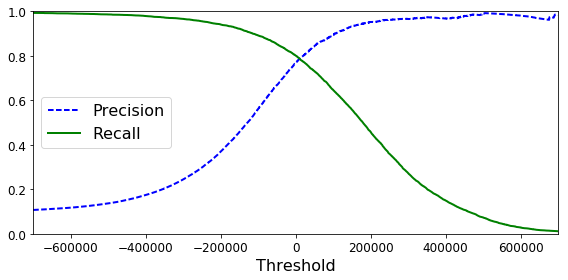

In [209]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="center left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

**Q3**:  Note the precision curve is bumpy while the recall curve is smooth.  Is that an
accident of the data?

**Q4**: The precision and recall curves cross when the score is 0. What does that tell us
about how our classifier is designed?

A very nice visualition of what's going on when varying threshholds, is just to take
the information from two curves above and plot precision vs recall.

Saving figure precision_vs_recall_plot


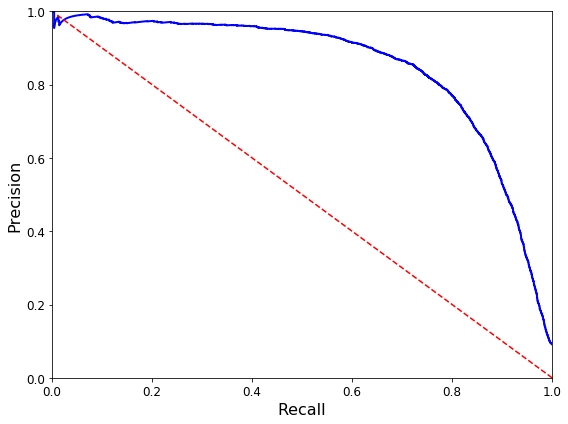

In [210]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    X= np.arange(1,0,-.01)
    # The red line
    Y = 1 - X
    plt.plot(X,Y,"r--")
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

This is a very healthy picture.  Precision drops as we increase recall (by varying the threshhold)
but it does so slowly, so that the arc of the curve, and therefore the area under it, is high.

Compare the red dashed line.  This roughly captures the behavior of a random
classifier that knows nothing about the problem.  We start with our baseline classifier
and a precision of 1.0 because we always say no, and as we gradually increase
the threshhold, we tend to linearly find more true positives, increasing
our recall, but reducing our precision at exactly the same rate.  The ideal classifier
gains in recall with minimal loss in precision, creating a high-arcing curve,
with maximal **Area Under the Curve** (AUC). The maximum area a curve could
have in this kind of graph is 1.0 (the entire area of the 1x1 square.  Therefore,
AUC is a nive threshhold-independent measure of the performance of a classifier.
The closer to 1.0 the better. Anything above .5 shows some degree of learning.


# F1 Score

In [25]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.78468208092485547

In [26]:
4344 / (4344 + (1077 + 1307)/2)

0.7846820809248555

In [33]:
(y_train_pred == (y_scores > 0)).all()

True

In [34]:
y_train_pred_90 = (y_scores > 70000)

In [35]:
precision_score(y_train_5, y_train_pred_90)

0.86592051164915484

In [36]:
recall_score(y_train_5, y_train_pred_90)

0.69931746910164172

# ROC curves

An alternative view of the performance of a classifier is the **receiver-operator characteristic**
(ROC), which plots **true-positive rate** against false positive rate.  The true-positive rate
is just another name for recall.  The false-positive rate is

$$
[\text{fpr}] = \frac{[\text{# negative data points with positive predictions}]}{\text{[# all positive predictions]}} = 1 - \frac{[\text{# positive data points with positive predictions}]}{[\text{# all positive predictions}]} = 1 - \text{Precision}
$$

In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


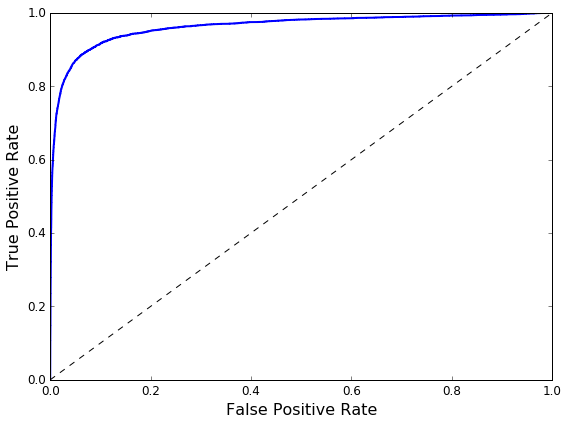

In [39]:
def plot_roc_curve(fpr, tpr, **options):
    plt.plot(fpr, tpr, linewidth=2, **options)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

The curve's shape  is different, reflecting a different tradeoff; as true positives go up so do false
positives.  The game is to gain in true positives with minimal gain in false positives, so a high arc reaching toward the upper left hand corner is best. Again, the area under the curve (AUC) is significant.

In [212]:
import sklearn.metrics
dir(sklearn.metrics)

['SCORERS',
 '__all__',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 '__path__',
 'accuracy_score',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'auc',
 'average_precision_score',
 'base',
 'brier_score_loss',
 'calinski_harabaz_score',
 'classification',
 'classification_report',
 'cluster',
 'cohen_kappa_score',
 'completeness_score',
 'confusion_matrix',
 'consensus_score',
 'coverage_error',
 'euclidean_distances',
 'explained_variance_score',
 'f1_score',
 'fbeta_score',
 'fowlkes_mallows_score',
 'get_scorer',
 'hamming_loss',
 'hinge_loss',
 'homogeneity_completeness_v_measure',
 'homogeneity_score',
 'jaccard_similarity_score',
 'label_ranking_average_precision_score',
 'label_ranking_loss',
 'log_loss',
 'make_scorer',
 'matthews_corrcoef',
 'mean_absolute_error',
 'mean_squared_error',
 'median_absolute_error',
 'mutual_info_score',
 'normalized_mutual_info_score',
 'pairwise',
 'pairwise_distances',
 'pairwise_distances_argmin',
 'pairwi

In [40]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.96244965559671547

Let's compare two different classifiers for their ROCs, and see how this visualization works.

Saving figure roc_curve_comparison_plot


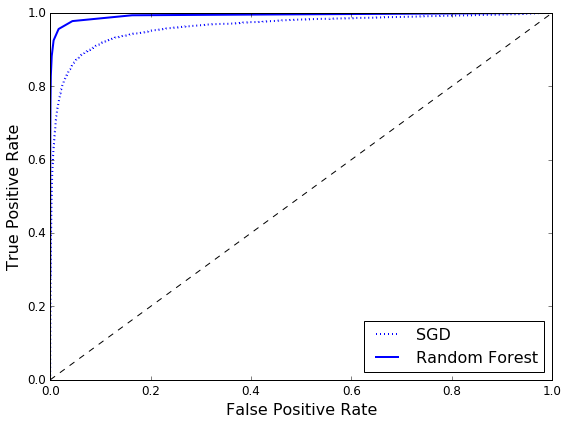

In [41]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

**Q**:  Which classifier is better?  Why?

In [42]:
roc_auc_score(y_train_5, y_scores_forest)

0.99312433660038291

In [43]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.98529734474434938

In [44]:
recall_score(y_train_5, y_train_pred_forest)

0.82826046854823832

# Multiclass classification

In [45]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [46]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

In [47]:
np.argmax(some_digit_scores)

5

In [48]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [49]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [50]:
len(ovo_clf.estimators_)

45

In [51]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [52]:
forest_clf.predict_proba([some_digit])

array([[ 0.1,  0. ,  0. ,  0.1,  0. ,  0.8,  0. ,  0. ,  0. ,  0. ]])

In [53]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.84063187,  0.84899245,  0.86652998])

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91011798,  0.90874544,  0.906636  ])

In [55]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]])

Saving figure confusion_matrix_plot


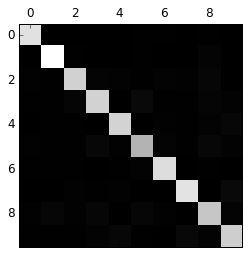

In [56]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mx)
    fig.colorbar(cax)

plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

Saving figure confusion_matrix_errors_plot


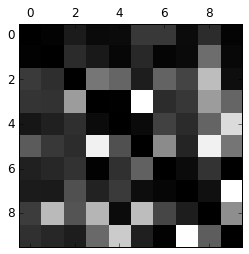

In [57]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Saving figure error_analysis_digits_plot


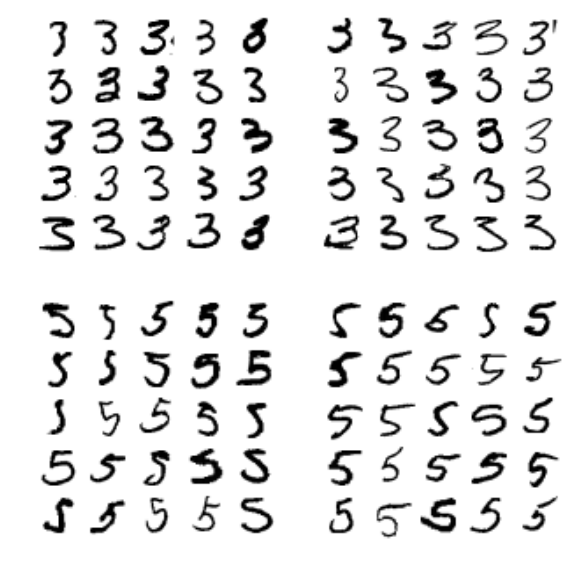

In [58]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

# Multilabel classification

In [59]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [60]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [61]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)

In [62]:
f1_score(y_train, y_train_knn_pred, average="macro")

0.96845540180280221

# Multioutput classification

In [63]:
noise = rnd.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = rnd.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


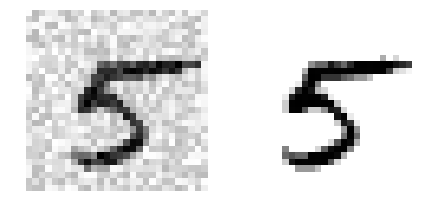

In [64]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

In [65]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Saving figure cleaned_digit_example_plot


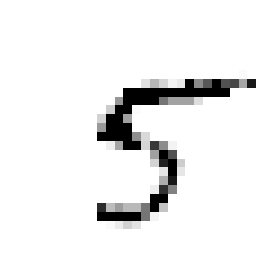

In [66]:
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")
plt.show()

# Extra material

## Dummy (ie. random) classifier

In [67]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

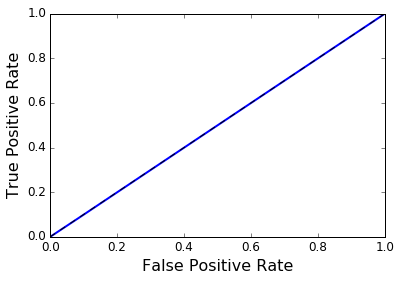

In [68]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## KNN classifier

In [69]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [70]:
y_knn_pred = knn_clf.predict(X_test)

In [71]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.97140000000000004

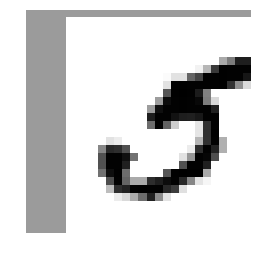

In [72]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [73]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [74]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [75]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [76]:
accuracy_score(y_test, y_knn_expanded_pred)

0.97629999999999995

In [77]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[ 0.       ,  0.       ,  0.5053645,  0.       ,  0.       ,
         0.       ,  0.       ,  0.4946355,  0.       ,  0.       ]])

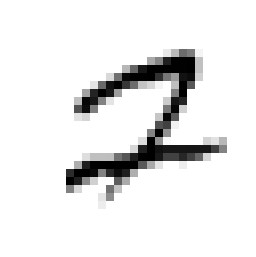

In [78]:
plot_digit(ambiguous_digit)

# Exercise solutions

**Coming soon**